# Overview

This notebook implements MiniBatch K-Means [1] for efficient prototype selection.

[1] D. Sculley, "Web-scale k-means clustering," in *Proc. 19th Int. World Wide Web Conf. (WWW)*, 2010, pp. 1177-1178.

## Usage Guide


1.   Set the values for M in the first cell by adding M values to the array
2.   Set the number of trials you would like for each value of M
3. Then `Run all` cells from the top down to run the experiment
4. The result table, chart, and accompanying logs will be available in the final cell of the notebook

Thank you!



In [1]:
# EXPERIMENT CONFIGURATION
Ms = [1000, 5000, 10000] # Ex: Ms = [1000, 5000, 10000]
num_trials = 3 # Number of trials per M

In [2]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import time
import kagglehub
import os
import shutil

In [3]:
def run_random_baseline(train_images, train_labels, M):
  """
  Our baseline. Randomly select M prototypes from the training set.
  """
  idx = torch.randperm(len(train_images))[:M]
  return train_images[idx], train_labels[idx]

In [4]:
def evaluate_1nn(S_images, S_labels, test_images, test_labels, batch_size=256):
  """
  Function to evaluate the 1-nearest neighbor classifier based on the
  prototype selection.
  """
  correct = 0
  total = 0

  with torch.no_grad():
      for i in range(0, len(test_images), batch_size):
          x_batch = test_images[i:i+batch_size]
          y_batch = test_labels[i:i+batch_size]

          # Compute distances to all prototypes
          dists = torch.cdist(x_batch, S_images)

          # Find nearest neighbor
          nn_indices = torch.argmin(dists, dim=1)
          predictions = S_labels[nn_indices]

          # Count correct predictions
          correct += (predictions == y_batch).sum().item()
          total += len(y_batch)

  return correct / total

In [5]:
def compute_confidence_interval(accuracies, confidence=0.95):
  """
  Compute mean and confidence interval.

  """
  # Compute mean and std
  accuracies = np.array(accuracies)
  n = len(accuracies)
  mean = np.mean(accuracies)
  std = np.std(accuracies, ddof=1)

  # Compute t value and margin
  t_value = stats.t.ppf((1 + confidence) / 2, n - 1)
  margin = t_value * std / np.sqrt(n)

  # Compute confidence intervals
  ci_lower = mean - margin
  ci_upper = mean + margin

  return mean, ci_lower, ci_upper, margin

In [6]:
def minibatch_kmeans(X, n_clusters, batch_size=256, max_iter=100, random_state=42):
  """
  MiniBatch K-Means clustering algorithm.

  Based on: Sculley, D. (2010). "Web-scale k-means clustering."
  Proceedings of WWW 2010.
  """
  torch.manual_seed(random_state)
  N, D = X.shape

  # Initialize centers by randomly sampling k points
  indices = torch.randperm(N)[:n_clusters]
  centers = X[indices].clone()

  # Per-center counts (for learning rate computation)
  counts = torch.ones(n_clusters)

  # Iterate over minibatches
  for iteration in range(max_iter):
    # Sample random minibatch
    batch_indices = torch.randint(0, N, (batch_size,))
    batch = X[batch_indices]

    # Cache nearest center for each x
    distances = torch.cdist(batch, centers)
    assignments = torch.argmin(distances, dim=1)

    for x_idx in range(len(batch)):
      # Get catched center for this x
      x = batch[x_idx]
      c_idx = assignments[x_idx].item()  # Line 10: c ← d[x]
      # Update per center counts
      counts[c_idx] += 1
      # Get per-center learning rate
      eta = 1.0 / counts[c_idx]
      # Take gradient step
      centers[c_idx] = (1 - eta) * centers[c_idx] + eta * x

  return centers

In [7]:
def run_kmeans_selection(train_images, train_labels, M):
    """
    Run K-Means Selection using MiniBatch K-Means.
    """
    start_time = time.time()

    print(f"\nRunning K-Means Selection with M={M}")

    prototypes = []
    prototype_labels = []

    prototypes_per_class = M // 10

    for digit in range(10):
        class_images = train_images[train_labels == digit]

        class_start = time.time()
        centers = minibatch_kmeans(
            class_images,
            n_clusters=prototypes_per_class,
            random_state=torch.randint(0, 1000000, (1,)).item()
          )
        prototypes.append(centers)
        prototype_labels.extend([digit] * prototypes_per_class)

        print(f"  Class {digit}: {len(class_images)} samples -> {prototypes_per_class} prototypes ({time.time() - class_start:.1f}s)")

    print(f"  Total time: {time.time() - start_time:.2f}s")

    return torch.cat(prototypes), torch.tensor(prototype_labels)

In [8]:
def plot_kmeans_results(results, Ms, num_trials, save_path_prefix='mnist_kmeans_results'):
  """
  Create separate plots for K-Means results.
  """
  colors = {'K-Means': '#2E86AB', 'Random': '#A23B72'}

  # Plot 1: Accuracy vs M
  fig1, ax1 = plt.subplots(figsize=(7, 5))

  for method_name in ['K-Means', 'Random']:
    means = []
    margins = []

    for M in Ms:
        mean, _, _, margin = compute_confidence_interval(results[method_name][M])
        means.append(mean * 100)
        margins.append(margin * 100)

    ax1.errorbar(
        Ms, means, yerr=margins,
        label=method_name,
        marker='o',
        markersize=8,
        linewidth=2,
        capsize=5,
        capthick=2,
        color=colors[method_name]
    )

  ax1.set_xlabel('Number of Prototypes (M)', fontsize=12, fontweight='bold')
  ax1.set_ylabel('Test Accuracy (%)', fontsize=12, fontweight='bold')
  ax1.set_title('Classification Accuracy vs Number of Prototypes',
                fontsize=13, fontweight='bold')
  ax1.legend(fontsize=11, loc='lower right')
  ax1.grid(True, alpha=0.3)
  ax1.set_xscale('log')
  ax1.set_xticks(Ms)
  ax1.set_xticklabels([f'{M:,}' for M in Ms])

  plt.tight_layout()
  acc_path = f"{save_path_prefix}_accuracy.png"
  plt.savefig(acc_path, dpi=300, bbox_inches='tight')
  print(f"\nAccuracy plot saved to: {acc_path}")
  plt.show()


  # Plot 2: Improvement over random
  fig2, ax2 = plt.subplots(figsize=(7, 5))

  improvements = []
  improvement_margins = []

  for M in Ms:
    km_mean, _, _, _ = compute_confidence_interval(results['K-Means'][M])
    rand_mean, _, _, _ = compute_confidence_interval(results['Random'][M])

    improvement = (km_mean - rand_mean) * 100
    improvements.append(improvement)

    _, _, _, km_margin = compute_confidence_interval(results['K-Means'][M])
    _, _, _, rand_margin = compute_confidence_interval(results['Random'][M])
    combined_margin = np.sqrt(km_margin**2 + rand_margin**2) * 100
    improvement_margins.append(combined_margin)

  bars = ax2.bar(
      range(len(Ms)), improvements,
      yerr=improvement_margins,
      color=colors['K-Means'],
      alpha=0.7,
      capsize=5
  )

  ax2.set_xlabel('Number of Prototypes (M)', fontsize=12, fontweight='bold')
  ax2.set_ylabel('Improvement over Random (%)', fontsize=12, fontweight='bold')
  ax2.set_title("K-Means vs Random Selection", fontsize=13, fontweight='bold')
  ax2.set_xticks(range(len(Ms)))
  ax2.set_xticklabels([f'{M:,}' for M in Ms])
  ax2.grid(True, axis='y', alpha=0.3)
  ax2.axhline(y=0, color='black', linestyle='--', linewidth=1)

  for bar, imp, margin in zip(bars, improvements, improvement_margins):
    height = bar.get_height()
    ax2.text(
        bar.get_x() + bar.get_width()/2., height,
        f'{imp:.2f}±{margin:.2f}',
        ha='center',
        va='bottom' if height > 0 else 'top',
        fontsize=9,
        fontweight='bold'
    )

  plt.tight_layout()
  imp_path = f"{save_path_prefix}_improvement.png"
  plt.savefig(imp_path, dpi=300, bbox_inches='tight')
  print(f"Improvement plot saved to: {imp_path}")
  plt.show()


In [9]:
def create_results_table(results, Ms, num_trials, save_path='results_table.png'):
  """
  Create a results table for K-Means vs Random selection
  """
  fig, ax = plt.subplots(figsize=(12, 6))
  ax.axis('tight')
  ax.axis('off')

  # Prepare table data
  table_data = []

  # Header row
  headers = ['M', 'Method', 'Accuracy (%)', '95% CI', 'Improvement (%)']
  table_data.append(headers)

  # Data rows
  for M in Ms:
    # K-Means row
    km_mean, km_lower, km_upper, km_margin = compute_confidence_interval(results['K-Means'][M])
    table_data.append([
        f'{M:,}',
        'K-Means',
        f'{km_mean*100:.2f} ± {km_margin*100:.2f}',
        f'[{km_lower*100:.2f}, {km_upper*100:.2f}]',
        ''
    ])
    # Random row
    rand_mean, rand_lower, rand_upper, rand_margin = compute_confidence_interval(results['Random'][M])
    table_data.append([
        '',
        'Random',
        f'{rand_mean*100:.2f} ± {rand_margin*100:.2f}',
        f'[{rand_lower*100:.2f}, {rand_upper*100:.2f}]',
        ''
    ])
    # Improvement row
    improvement = (km_mean - rand_mean) * 100
    table_data.append([
        '',
        'Improvement',
        '',
        '',
        f'+{improvement:.2f}'
    ])
    # Separator row
    if M != Ms[-1]:
        table_data.append(['', '', '', '', ''])

  # Create table
  table = ax.table(cellText=table_data,
                  cellLoc='center',
                  loc='center',
                  colWidths=[0.15, 0.2, 0.25, 0.25, 0.15])

  # Add title and caption
  plt.title('MiniBatch K-Means vs Random Selection\n' +
            f'MNIST Dataset, 1-NN Classifier, {num_trials} trials per configuration',
            fontsize=14, fontweight='bold', pad=20)

  plt.tight_layout()
  plt.savefig(save_path, dpi=300, bbox_inches='tight')
  print(f"\nTable saved to: {save_path}")
  plt.show()

In [10]:
def run_kmeans_experiments(train_dataset, test_dataset, Ms=[1000, 5000, 10000], num_trials=3):
  """
  Run experimental comparison of Mini Batch K-Means vs Random selection.
  """
  # Load test and train data
  train_images = torch.stack([img for img, _ in train_dataset])
  train_labels = torch.tensor([label for _, label in train_dataset])
  test_images = torch.stack([img for img, _ in test_dataset])
  test_labels = torch.tensor([label for _, label in test_dataset])

  # Flatten images to vectors
  train_images = torch.flatten(train_images, start_dim=1)
  test_images = torch.flatten(test_images, start_dim=1)

  # Initialize results storage
  results = {
      'K-Means': {M: [] for M in Ms},
      'Random': {M: [] for M in Ms}
  }

  # Run experiments
  for M in Ms:
    print(f"\n{'#'*70}")
    print(f"# Testing M = {M:,}")
    print(f"{'#'*70}")

    for trial in range(num_trials):
      print(f"\n{'*'*70}")
      print(f"* Trial {trial + 1} / {num_trials}")
      print(f"{'*'*70}")

      # Random baseline
      print("\n[Random Selection]")
      start = time.time()
      R_images, R_labels = run_random_baseline(train_images, train_labels, M)
      rand_time = time.time() - start
      rand_acc = evaluate_1nn(R_images, R_labels, test_images, test_labels)
      results['Random'][M].append(rand_acc)
      print(f"Time: {rand_time:.2f}s")
      print(f"Accuracy: {rand_acc*100:.2f}%")
      print(f"Prototypes selected: {len(R_images)}")

      # K-Means
      print("\n[K-Means Selection]")
      KM_images, KM_labels = run_kmeans_selection(train_images, train_labels, M)
      km_acc = evaluate_1nn(KM_images, KM_labels, test_images, test_labels)
      results['K-Means'][M].append(km_acc)
      print(f"Accuracy: {km_acc*100:.2f}%")
      print(f"Prototypes selected: {len(KM_images)}")

  return results

100%|██████████| 22.0M/22.0M [00:00<00:00, 193MB/s]

Extracting files...



100%|██████████| 9.91M/9.91M [00:00<00:00, 41.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.19MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.65MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.4MB/s]



 K-Means Prototype Selection - MNIST Experiments

######################################################################
# Testing M = 1,000
######################################################################

**********************************************************************
* Trial 1 / 3
**********************************************************************

[Random Selection]
Time: 0.02s
Accuracy: 88.46%
Prototypes selected: 1000

[K-Means Selection]

Running K-Means Selection with M=1000
  Class 0: 5923 samples -> 100 prototypes (1.9s)
  Class 1: 6742 samples -> 100 prototypes (1.9s)
  Class 2: 5958 samples -> 100 prototypes (1.9s)
  Class 3: 6131 samples -> 100 prototypes (3.0s)
  Class 4: 5842 samples -> 100 prototypes (1.9s)
  Class 5: 5421 samples -> 100 prototypes (1.9s)
  Class 6: 5918 samples -> 100 prototypes (2.0s)
  Class 7: 6265 samples -> 100 prototypes (1.9s)
  Class 8: 5851 samples -> 100 prototypes (2.0s)
  Class 9: 5949 samples -> 100 prototypes (2.9s)
  Tot

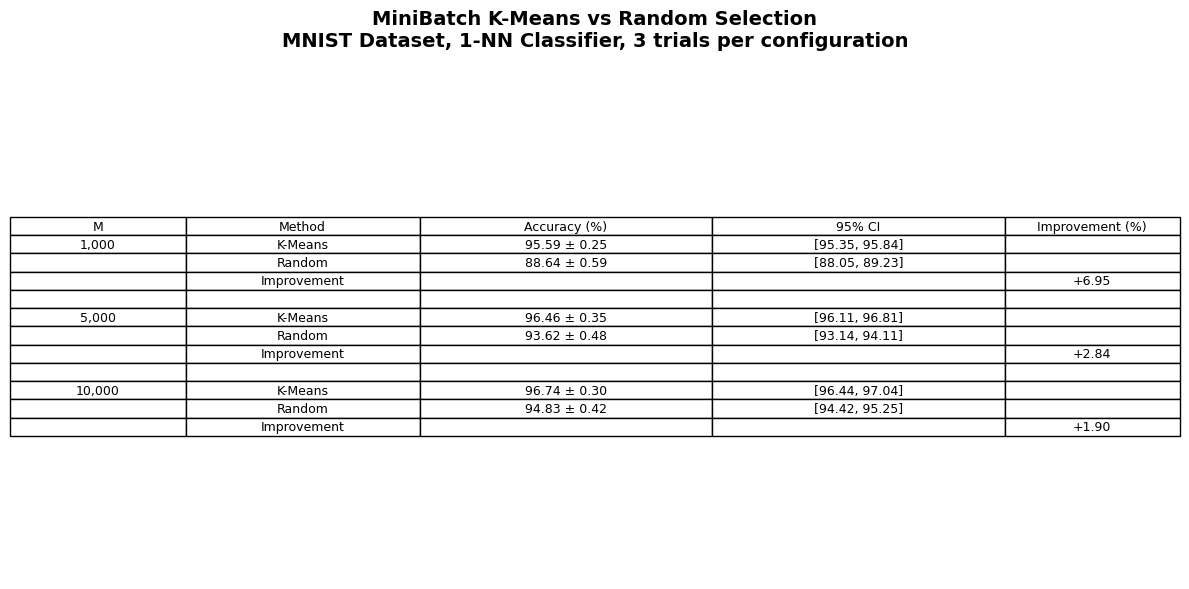


Accuracy plot saved to: mnist_kmeans_results_accuracy.png


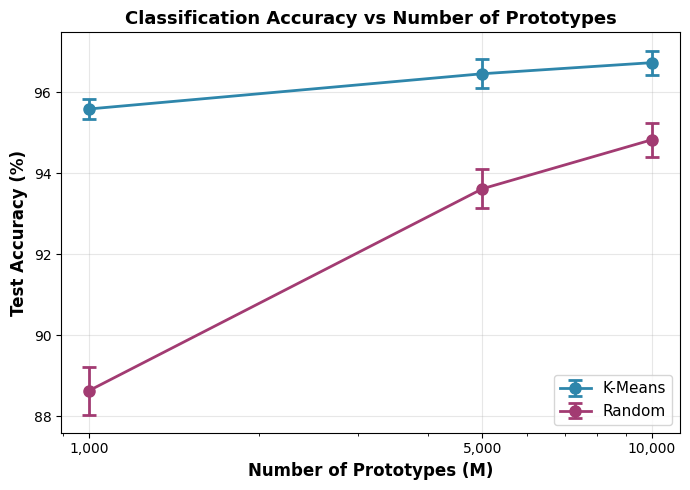

Improvement plot saved to: mnist_kmeans_results_improvement.png


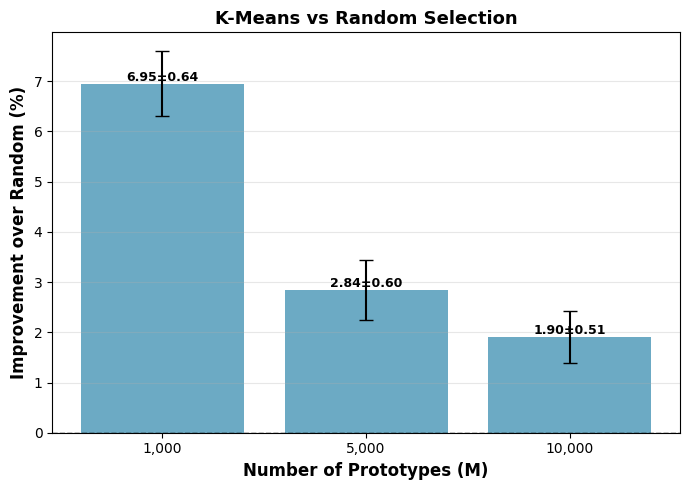

In [11]:
# Download MNIST Dataset and copy it to a writable path
path = kagglehub.dataset_download("hojjatk/mnist-dataset")
writable_path = './mnist_writable'
if os.path.exists(writable_path):
    shutil.rmtree(writable_path)
shutil.copytree(path, writable_path)

transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load the training dataset
train_dataset = datasets.MNIST(root=writable_path, train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root=writable_path, train=False, download=True, transform=transform)

print("\n" + "="*70)
print(" K-Means Prototype Selection - MNIST Experiments")
print("="*70)

# Run experiments
results = run_kmeans_experiments(train_dataset, test_dataset, Ms=Ms, num_trials=num_trials)

# Print results
create_results_table(results, Ms, num_trials)

# Create plots
plot_kmeans_results(results, Ms, num_trials)